# cADpyr e-model showcase

This notebook will showcases various model respones of the detailed morphology cADpyr e-model.

This notebook can be reused with any neuron e-model  with pyramidal neuron morphology.
User can replace the emodel files (hoc, morphology and mechanism files) to generate such responses for any such model.


Download the e-model folder from [here](https://openbraininstitute.sharepoint.com/:f:/s/OBI-Scientificstaff/Ei3QIGh3JFFHkRkY7LRyTpEBm8eUll7HGyusulkPavf5SA?e=7ihV8H) in OneDrive `OBI -> Scientific staff -> Documents -> Data -> Analysis notebook data -> cadpyr_emodel`

For running this example, the downloaded folder `cadpyr_emodel` was kept here `./Cellular/emodels` of this repository. If you use a different path, please update `emodel_folder_path` variable.

Let's first compile the mechanisms using `nrnivmodl`.

In [ ]:
from pathlib import Path
emodel_folder_path=Path("../cadpyr_emodel")

import os
os.system(f"nrnivmodl {emodel_folder_path}/mechanisms")

## If the above statement does not work for you, use the following
# use the follwing:
#!path_to_your_venv/bin/nrnivmodl path_to_mechanisms_dir

In [38]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
import seaborn as sns
sns.set_style("whitegrid")

from bluecellulab import Cell, Simulation
from bluecellulab.circuit.circuit_access import EmodelProperties
from bluecellulab.simulation.neuron_globals import NeuronGlobals
from bluecellulab.tools import calculate_rheobase
from bluecellulab.stimulus import StimulusFactory
from bluecellulab.stimulus.circuit_stimulus_definitions import Hyperpolarizing
from bluecellulab.analysis.analysis import compute_plot_iv_curve, compute_plot_fi_curve
import neuron

import json
import numpy as np
from scipy.optimize import curve_fit
import currentscape

### Setting Up the Model

We begin by defining the paths for our `hoc` and `morphology` files. The `hoc` file provides a high-level description of our cell's properties and geometry, while the `morphology` file gives details about the cell's physical structure.

Upon specifying these paths, we instantiate our emodel using `bluecellulab`'s `Cell` class, leveraging the `v6` template format which is the default format for Brain Brain Project (BBP) single cell template formats. It is just a version number for formats and has no scientific significance :). 

If you replace, example e-model with your own (even non-BBP) model, you can still use this format as we will calculate the threshold and holding current needed during template declaration.

In [39]:
# Define the hoc and morphology file paths
emodel_name = "cadpyr_emodel" # name of your emodel
hoc_file = emodel_folder_path / "model.hoc"
morph_file = emodel_folder_path / "C060114A5.asc"

We need the threshold and holding currents for the model. We will use the `EModel` resource of an e-model. This resource was downloaded from the corresponding EModel page of the Open Brain Platform.

If you do not have the file, we can calculate the threshold current using built-in function in BlueCelluLab. In this case, we will set the holding current = 0 and use the `calculate_rheobase` function for threshold calculation. You can skip the next two notebook cells.

In [40]:
EM_file = f"{emodel_folder_path}/EM__emodel=cADpyr__etype=cADpyr__mtype=L5_TPC_A__species=mouse__brain_region=grey__iteration=1372346__13.json"

with open(EM_file, "r") as f:
    em_data = json.load(f)
em_data.keys()

dict_keys(['fitness', 'parameter', 'score', 'features', 'scoreValidation', 'passedValidation', 'seed'])

These keys have been described in example `Cellular/emodels/parameters_plot/README.md`. We will use the `features` key which is a list and find the feature values for threshold and holding currents. Each element of the list is a dictionary with name, values and units:

In [41]:
em_data["features"][0]

{'name': 'IDrest_130.soma.v.Spikecount', 'value': 17.0, 'unitCode': ''}

In [42]:
# set the holding current and threshold current as None
holding_current=None
threshold_current=None

for feat in em_data["features"]:
    # print(feat)
    if feat["name"]=="SearchHoldingCurrent.soma.v.bpo_holding_current":
        holding_current = feat["value"]

    if feat["name"]=="SearchThresholdCurrent.soma.v.bpo_threshold_current":
        threshold_current = feat["value"]

print("holding_current", holding_current)
print("threshold_current", threshold_current)

holding_current -0.08750000000000001
threshold_current 0.1624028733588378


If the threshold and holding current is missing, we set them to zero to initialise the `Cell` class object. Threshold current is calcuated ahead.

In [43]:
if holding_current is None:
    print("No holding current provided, will set it to 0.")
    holding_current = 0
    
# Variable to decide whether to use `calculate_rheobase()` ahead.
compute_threshold = False
if threshold_current is None:
    compute_threshold = True
    # threshold current is calculated ahead after the next notebook cell
    # For preliminary initialization of the `Cell` class, set it to 0
    threshold_current = 0

To initialise the cell template, we need to define the `EmodelProperties` object which takes the `threshold_current` and `holding_current` and `AIS_Scaler` as arguments.

`AIS_Scaler` is factor by which the diameter of the AIS (axon initial segment) is scaled. As the AIS was not scaled for the `cADpyr` e-model and all other Blue Brain Project e-models on OBP, we use `AIS_scaler=1.0`.

In [44]:
emodel_properties = EmodelProperties(threshold_current=threshold_current,
                                     holding_current=holding_current,
                                     AIS_scaler=1.0)
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

If the threshold current is zero (the case of missing EModel json file with final paramters), we will use the `calculate_rheobase` functions of BlueCelluLab.

In [45]:
if compute_threshold:
    print("No threshold current provided, will attempt to compute it. This will take a few seconds...")
    emodel_properties.threshold_current = calculate_rheobase(cell)

The `cell` object is a bluecellulab (BCL) object and cell.cell is the NEURON simulator's hoc object. 

In [46]:
print(type(cell))
print(type(cell.cell))

<class 'bluecellulab.cell.core.Cell'>
<class 'hoc.HocObject'>


The BCL cell object has provides the several inbuilt properties which help during the simulation of the neuron. 

In [47]:
# dir(cell)

In [48]:
print(f"Holding current of the emodel is {cell.hypamp}")      # emodel holding current
print(f"Threshold current of the emodel is {cell.threshold}")   # emodel threshold current
print(f"The child sections of the soma are:") 
cell.soma.children()    # child sections of the some

Holding current of the emodel is -0.08750000000000001
Threshold current of the emodel is 0.1624028733588378
The child sections of the soma are:


[cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].apic[0],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[63],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[62],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[51],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[44],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[41],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[30],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[27],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[8],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].dend[0],
 cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].axon[0]]

If you have experience with the NEURON simulator, you can use with the `cell.cell` object directly to access NEURON commands e.g.

In [49]:
print(f"NEURON soma section of emodel {cell.cell.soma[0]}")
print(cell.cell.soma[0](0.5).v)
print(neuron.h.area(0.5, sec=cell.cell.soma[0]))

NEURON soma section of emodel cADpyr_bin_4_bluecellulab_a82ab2ffb42e424c888f85f87bc3e303[0].soma[0]
0.0
715.7186136018619


To set the NEURON simulator's global variables such as

- `v_init` sets the initial membrane potential of our cell model
- `celsius` determines the temperature at which the simulation runs 

In [50]:

print(neuron.h.celsius)
print(neuron.h.v_init)
neuron_globals = NeuronGlobals.get_instance()
neuron_globals.celsius = 34.0
neuron_globals.v_init = -70.0

print(neuron.h.celsius)
print(neuron.h.v_init)


34.0
-70.0
34.0
-70.0


To learn more about the basic functions of bluecellulab, use the single cell example [notebook](https://github.com/openbraininstitute/BlueCelluLab/blob/main/examples/1-singlecell/singlecell.ipynb).

In the present example, we will visualise various electrical properties of cADpyr neuron emodel.

## Emodel responses for different stimulus protocols

We will create different protocols such depolarising steps, hyperpolarising steps, etc. and plot the responses for each one of the protocols.

We will create each stimulus object add is to a dictionary then rum and plot the stimuli.

In [51]:
stim_factory = StimulusFactory(dt=0.1)
all_stim_objects ={}

# IDrest
idrest_amps = [130, 200, 250, 300]

for amp in idrest_amps:
    all_stim_objects[f"IDRest_{amp}"] = stim_factory.idrest(threshold_current=threshold_current, # threshold current of the cell
                                                          threshold_percentage=amp)

# IV
iv_amps = [-100, -40, 0]

for amp in iv_amps:
    all_stim_objects[f"IV_{amp}"] = stim_factory.iv(threshold_current=threshold_current, # threshold current of the cell 
                                                    threshold_percentage=amp)

# APWaveform
apwaveform_amps = [280]
apwaveform_stim_list = []
for amp in apwaveform_amps:
    all_stim_objects[f"APWaveform_{amp}"] = stim_factory.ap_waveform(
                                                              threshold_current=threshold_current, # threshold current of the cell 
                                                              threshold_percentage=amp)

# IDhyperpol_150
# We need to combine stimuli to ge thte desired shape
# see Bluecellulab example https://github.com/openbraininstitute/BlueCelluLab/blob/main/examples/5-stimuli/stimuli.ipynb
# for more details

idhyperpol_amp = 150 # 150 %
hyp_amp_perc=-70

# hyperpol step
# We create a combined step with a hyperlpolarisation step and a depolarisation step
idh1 = stim_factory.idrest(threshold_current=threshold_current, # threshold current of the cell 
                         threshold_percentage=hyp_amp_perc)
#start after idh1 ends
idh2 = stim_factory.idrest(threshold_current=threshold_current, # threshold current of the cell 
                         threshold_percentage=idhyperpol_amp)

# combine the two steps
idhyperpol = idh1 + idh2

all_stim_objects[f"IDHyperpol_{idhyperpol_amp}"] = idhyperpol


In [52]:
# create a single list with all the stimuli
# create a responses dictionary with name of the stimuli as key and response as value
responses = {}
for name, stim in all_stim_objects.items():
    print(f"Running simulation for {name}")
    # create a new cell object for each stimulus
    cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
    cell.inject_current_waveform(t_content=stim.time, i_content=stim.current)
    #create a simulation object
    sim = Simulation(cell)
    # use stimulus_time to get the duration of the stimulus in ms to run the simulation
    duration = stim.stimulus_time
    sim.run(duration, dt=0.1)
    print("Done.")
    time, voltage = cell.get_time(), cell.get_soma_voltage()
    responses[name] = (time, voltage)


Running simulation for IDRest_130
Done.
Running simulation for IDRest_200
Done.
Running simulation for IDRest_250
Done.
Running simulation for IDRest_300
Done.
Running simulation for IV_-100
Done.
Running simulation for IV_-40
Done.
Running simulation for IV_0
Done.
Running simulation for APWaveform_280
Done.
Running simulation for IDHyperpol_150
Done.


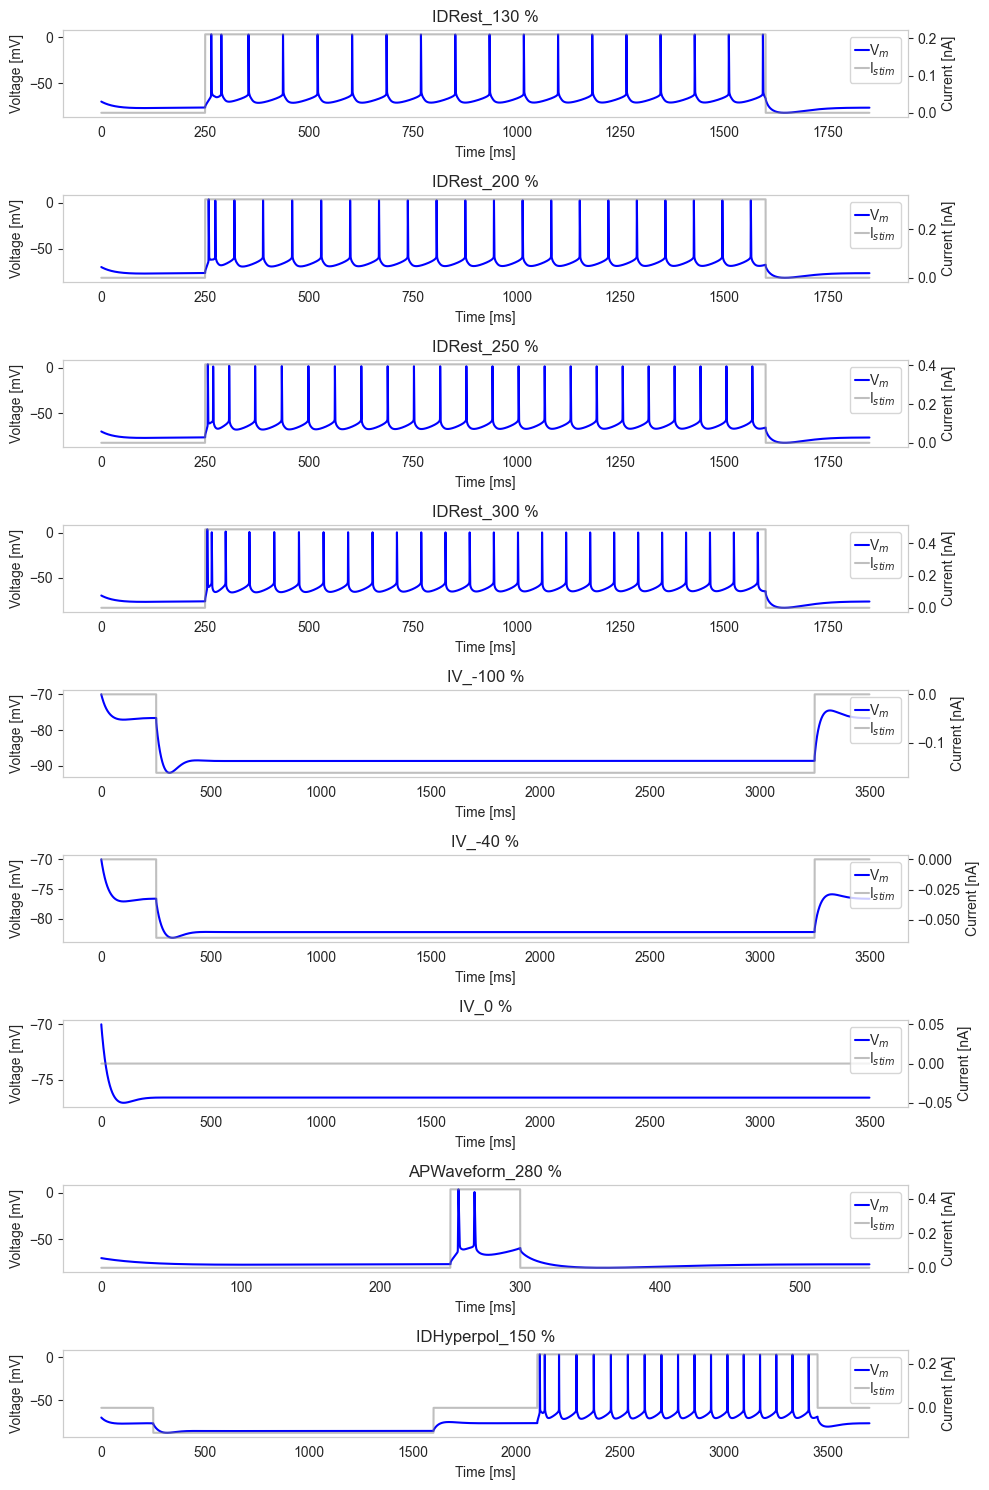

In [53]:
fig, axs = plt.subplots(len(responses), 1, figsize=(10, 15))

for i, (name, (time, voltage)) in enumerate(responses.items()):
    ax = axs[i]
    # Plot voltage on left y-axis
    line1, = ax.plot(time, voltage, color='blue', label='voltage')
    ax.set_title(name+" %")
    ax.set_ylabel("Voltage [mV]")
    ax.set_xlabel("Time [ms]")
    
    # Plot stimulus on right y-axis
    ax_right = ax.twinx()
    stim = all_stim_objects[name]
    line2, = ax_right.plot(stim.time, stim.current, color="grey", alpha=0.5, label='current')
    ax_right.set_ylabel("Current [nA]")
    
    # Create legend
    ax_right.legend(handles=[line1, line2], 
                   labels=['V$_m$', 'I$_{stim}$'],
                   loc='upper right',
                   handlelength=1.0,      # Length of the legend lines
                   handleheight=1.0)      # Height of the legend lines
    
    # hide grid lines
    ax.grid(False)
    ax_right.grid(False)

plt.tight_layout()
plt.show()


## Currentscape

See the `single_cell_currentscape_analysis` notebook for more details

Running the simulation...
Done.


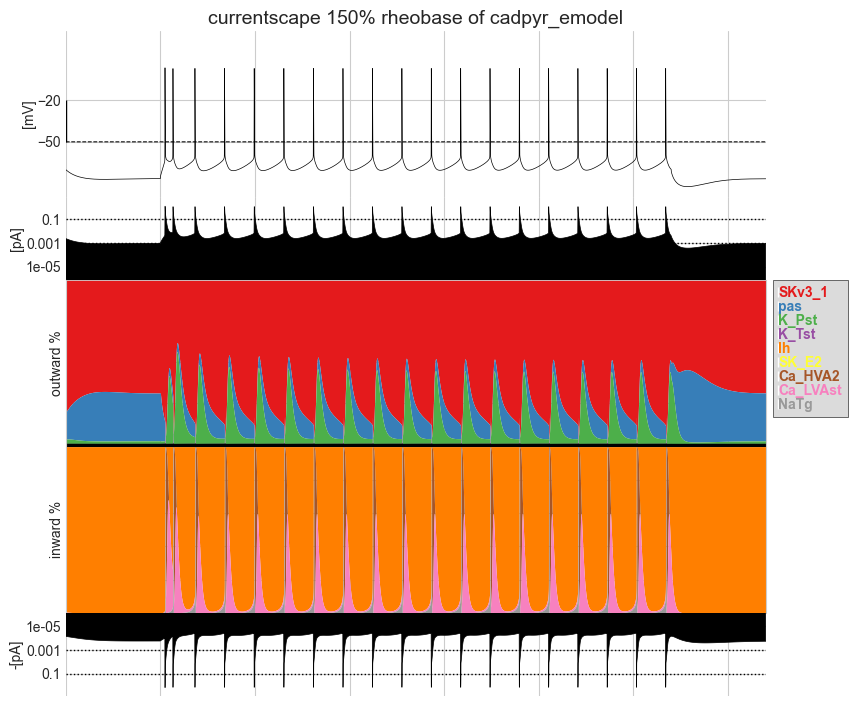

In [54]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

# we will use a Step_150% protocol to plot the currentscape
threshold_percentage = 150
stim_factory = StimulusFactory(dt=0.1)
stim = stim_factory.idrest(
    threshold_current=emodel_properties.threshold_current,
    threshold_percentage=threshold_percentage
)

# give the list of currents to plot
ion_channels = {
    "SKv3_1": "ik",
    "K_Pst": "ik",
    "SK_E2": "ik",
    "K_Tst": "ik",
    "Ca_LVAst": "ica",
    "Ca_HVA2": "ica",
    "NaTg": "ina",
    # "Nap_Et2": "ina",  # mechanism not in soma
    "Ih": "ihcn",
    "pas": "i",
}

# add recording for each ion channel
current_rec_names = [
    f"self.soma(0.5)._ref_{curr_name}_{ion_channel}"
    for ion_channel, curr_name 
    in ion_channels.items()
]
for current_rec in current_rec_names:
    cell.add_recording(current_rec)

# inject the current
cell.inject_current_waveform(t_content=stim.time, i_content=stim.current)
sim = Simulation(cell)
print("Running the simulation...")
sim.run(stim.stimulus_time, dt=0.1)
print("Done.")

currents = []
time, voltage = cell.get_time(), cell.get_soma_voltage()
for current_rec in current_rec_names:
    currents.append(cell.get_recording(current_rec))

# plot the currentscape with configuration
currentscape_config = {
    "current": {"names": list(ion_channels.keys())},
    "output": {
        "savefig": False,
        "dir": ".",
        "fname": f"currentscape-{emodel_name}-step{threshold_percentage}",
        "extension": "pdf",
        "transparent": False
    },
    "title": f"currentscape {threshold_percentage}% rheobase of {emodel_name}",
    "titlesize": 14,
    "legend": {
        "textsize": 10
    },
    "figsize": [10, 7],
    "textsize": 10
}

fig = currentscape.plot(
    voltage,
    currents,
    currentscape_config,
    ions_data=None,
    time=time,
)
plt.show()

## FI Curve at soma

See `plot_iv_fi_curve` notebook for more details

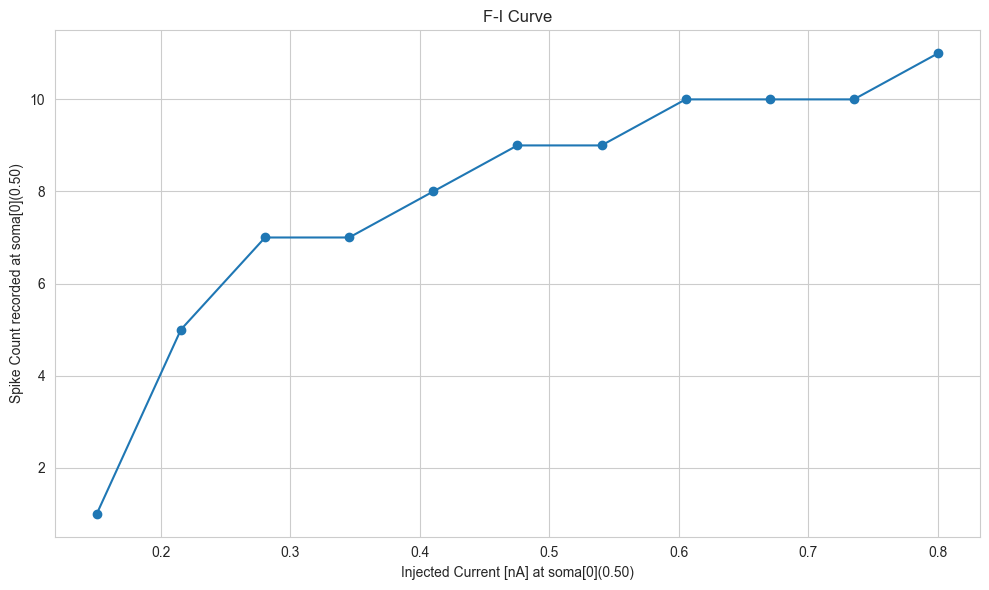

In [55]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

_, _ = compute_plot_fi_curve(cell)

## IV Curve at soma

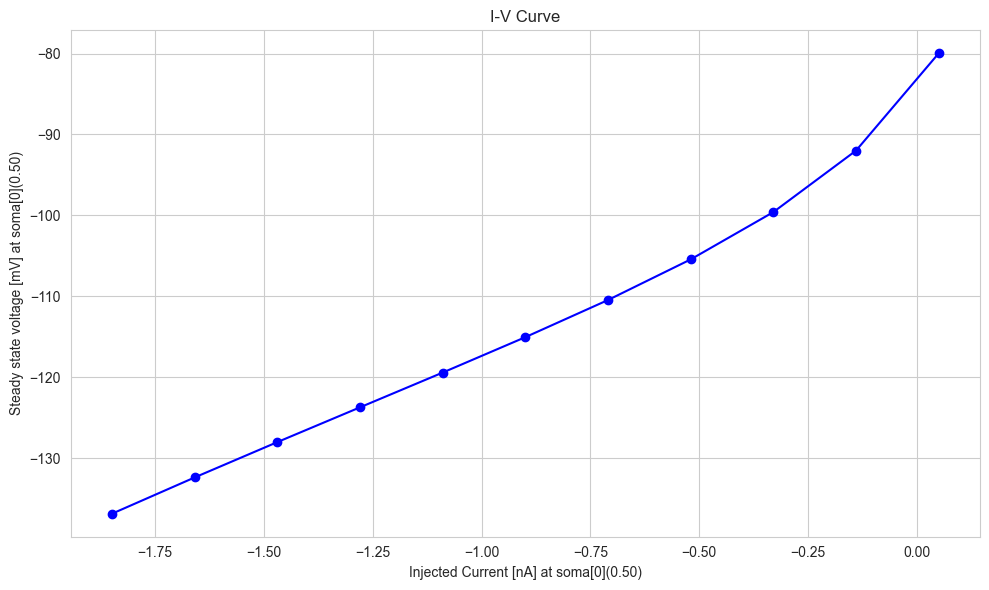

In [56]:
_, _ = compute_plot_iv_curve(cell)


## Record from AIS (Axon Initial Segment)
The `Cell` class methods: `get_soma_voltage()` and `get_ais_voltage()` add voltage recordings at `soma[0](0.5)` and `axonal[1](0.5)` locations of the cell. We will use a ramp stimulus at the soma(0.5) of the cell.

Text(0, 0.5, 'Voltage (mV)')

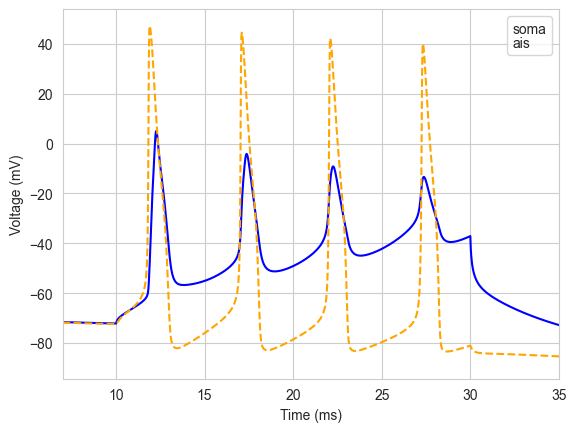

In [57]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
cell.add_ramp(start_time=10.0, stop_time=30.0, start_level=0.5, stop_level=4.0)
sim = Simulation()
sim.add_cell(cell)
cell.add_ais_recording(dt=cell.record_dt)

sim.run(45, cvode=False)

time = cell.get_time()
soma_voltage = cell.get_soma_voltage()
ais_voltage = cell.get_ais_voltage()
ß
plt.plot(time, soma_voltage, label="soma", linestyle="-", color= "blue")
plt.plot(time, ais_voltage, label="ais", linestyle="--", color= "orange")
plt.xlim(7, 35)
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

You can see the dashed orange traces from the `axon[1](0.5)` show that the spike generates first in the axon and then in the soma

## Record all sections

In [58]:
from bluecellulab.stimulus.circuit_stimulus_definitions import OrnsteinUhlenbeck, ShotNoise
from bluecellulab import RNGSettings

In [59]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
stimulus = OrnsteinUhlenbeck(
            target="single-cell", delay=15, duration=20,
            tau=2.8, sigma=0.64, mean=0.729, mode="current_clamp", dt=0.25, seed=1
        )
rng_obj = RNGSettings.get_instance().set_seeds(base_seed=42)
sim = Simulation()
sim.add_cell(cell)


In [60]:
time_vec, stim_vec = cell.add_ornstein_uhlenbeck(cell.soma, 0.5, stimulus, stim_count=1)
# plt.plot(time_vec, stim_vec)
# plt.xlabel("Time (ms)")
# plt.ylabel("Current (nA)")

With `add_allsections_voltagerecordings` we enable recording from every section of the cell and `get_allsections_voltagerecordings` gets all the recordings.

In [61]:
cell.add_allsections_voltagerecordings()
sim.run(45, cvode=False)
recordings = cell.get_allsections_voltagerecordings()
time = cell.get_time()

`recordings` has all the recordings from all the cell secitons at the 0.5 location. See the recordings below

In [62]:
recordings

{'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].soma[0]': array([-70.        , -69.00333646, -68.38060931, ..., -81.75672409,
        -81.76421577, -81.77169029]),
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].dend[0]': array([-70.        , -69.47616339, -69.03096341, ..., -81.67183021,
        -81.67949483, -81.68714177]),
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].dend[1]': array([-70.        , -69.83737681, -69.63202124, ..., -81.57314795,
        -81.5810133 , -81.58886037]),
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].dend[2]': array([-70.        , -69.99444467, -69.97433718, ..., -81.47774664,
        -81.48580527, -81.49384504]),
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].dend[3]': array([-70.        , -70.00116623, -69.99680801, ..., -81.37043714,
        -81.37870614, -81.3869556 ]),
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].dend[4]': array([-70.        , -69.9

Here in order to display how the voltage changes in different sections, we plot the voltage of the soma and its subsections. We will record voltages at the center (or (0.5) location) of each section.

We use the `subtree` method to get the subsections.

In [63]:
subtree = [x.name() for x in cell.soma.subtree()][:10]
subtree

['cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].soma[0]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[0]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[116]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[118]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[120]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[119]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[117]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[1]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[108]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[111]']

We will now plot the voltages recorded for different locations in the subtree. We want to show the distances from the soma of the recording locations along with the section name.
We will also plot voltage recordings from the soma and the axon initial segment.

To calculate the distance of each section from the soma, we use the `distance` method from NEURON. The `select_dendritic_recordings` and `distances_to_soma` methods will be used to select the dendritic recordings and calculate the distances to the soma.

In [64]:
from itertools import islice

def select_dendritic_recordings(all_recordings):
        """Select dendritic recordings from all recordings."""
        res = {}
        for key, value in all_recordings.items():
            if "myelin" in key:
                continue
            else:
                res[key] = value
        return res

def distances_to_soma():
    """Return the distance to the soma for each section."""
    res = {}
    all_recordings = cell.get_allsections_voltagerecordings()
    dendritic_recordings = select_dendritic_recordings(all_recordings)
    soma = cell.soma
    for key in dendritic_recordings.keys():
        section_name = key.rsplit(".")[-1].split("[")[0]  # e.g. "dend"
        section_idx = int(key.rsplit(".")[-1].split("[")[1].split("]")[0])  # e.g. 0
        attribute_value = getattr(cell.cell.getCell(), section_name)
        section = next(islice(attribute_value, section_idx, None))
        # section e.g. cADpyr_L2TPC_bluecellulab_x[0].dend[0]
        res[key] = neuron.h.distance(soma(0.5),section(0.5))
    return res

We now calculate the distances of the sections to the soma and plot the voltages recorded from the soma and the axon initial segment.

In [65]:
distances = distances_to_soma()
distances = {k: float(v) for k, v in distances.items()} # convert to float
distances = dict(sorted(distances.items(), key=lambda x: x[1])) # sort by distance

In the plot above, the colour intensity is given by the order of subtree.

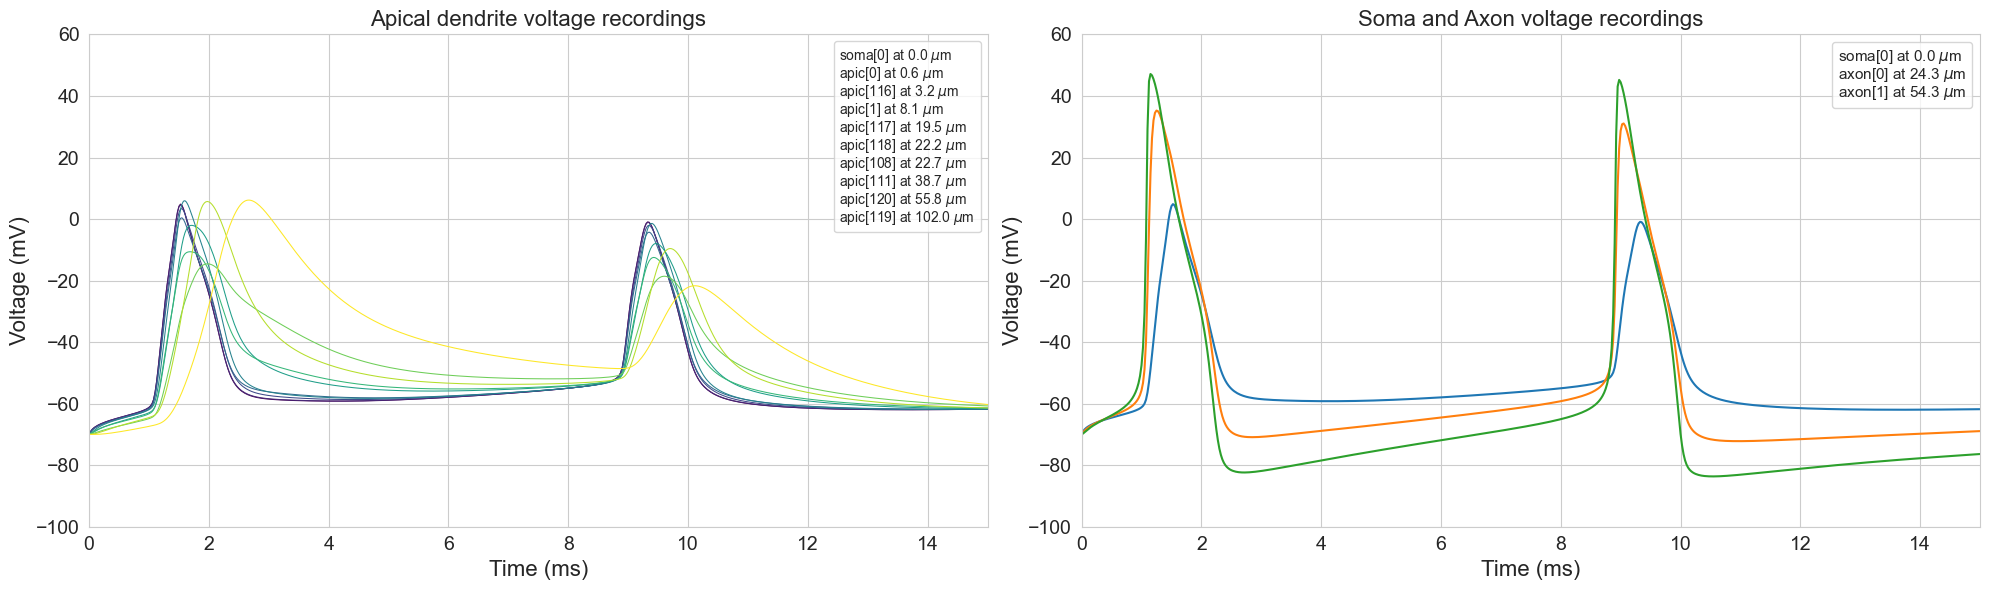

In [66]:
# Define colormap
color_map = get_cmap('viridis', len(subtree))
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

title_fontsize = 16
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 11

recordings_subtree = {key: recordings[key] for key in subtree}
i=0

# Plot the voltage recordings from the subtree
for key in distances:
        if key in subtree:
                voltage = recordings[key]
                ax[0].plot(time, voltage, label=f'{key.split(".")[-1]} at {round(distances[key], 1)} $\\mu$m', linewidth=0.75, color=color_map(i))
                i+=1

ax[0].legend(loc="upper right")#, bbox_to_anchor=(0.6, 1.0),fontsize=legend_fontsize)
ax[0].set_title("Apical dendrite voltage recordings", fontsize=title_fontsize)
ax[0].set_xlim(0, 15)
ax[0].set_ylim(-100, 60)
ax[0].set_xlabel("Time (ms)", fontsize=label_fontsize)
ax[0].set_ylabel("Voltage (mV)", fontsize=label_fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)


# Plot soma and axon voltage recordings
color_map = get_cmap('tab10', len(subtree))
i=0
for key in distances.keys():
    if "axon" in key or "soma" in key:
        label = f'{key.split(".")[-1]} at {round(distances[key], 1)} $\\mu$m'
        ax[1].plot(time, recordings[key], label=label, color=color_map(i))
        i+=1

ax[1].legend(fontsize=legend_fontsize)
ax[1].set_title("Soma and Axon voltage recordings",fontsize=title_fontsize)
ax[1].set_xlim(0, 15)
ax[1].set_ylim(-100, 60)
ax[1].set_xlabel("Time (ms)",fontsize=label_fontsize)
ax[1].set_ylabel("Voltage (mV)",fontsize=label_fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()

Figure description:

Left: The voltages in the soma and different sections along the apical dendrite. With increasing distance from the soma, the membrane potential decreases in amplitude.

Right: The voltages in the soma and the AIS sections: axon[0] and axon[1]. The spike initiation (see between 0-2 ms) occurs in axon[0] section slightly before than that in the soma.

## bAP: Backpropagating Action Potentials

The `get_peak_index` function is a helper function that locates the index of the maximum value (peak) in the voltage array within a given interval, corresponding to the time of peak voltage.

In [67]:
def get_peak_index(voltage, stim_start: int, stim_end: int) -> int:
    """Get the peak voltage from a trace."""
    return voltage[stim_start:stim_end].argmax() + stim_start

### Creating the BPAP Class

In [68]:
class BPAP:

    def __init__(self, cell: Cell) -> None:
        self.cell = cell
        self.dt = 0.025
        self.stim_start = 1000
        self.stim_duration = 1

    @property
    def start_index(self) -> int:
        """Get the index of the start of the stimulus."""
        return int(self.stim_start / self.dt)

    @property
    def end_index(self) -> int:
        """Get the index of the end of the stimulus."""
        return int((self.stim_start + self.stim_duration) / self.dt)

    def select_dendritic_recordings(self, all_recordings : dict[str, float]) -> dict[str, float]:
        """Select dendritic recordings from all recordings."""
        res = {}
        for key, value in all_recordings.items():
            if "myelin" in key:
                continue
            elif "axon" in key:
                continue
            else:
                res[key] = value
        return res

    def run(self, duration: float, amplitude: float) -> None:
        """Apply depolarization and hyperpolarization at the same time."""
        sim = Simulation()
        sim.add_cell(self.cell)
        self.cell.add_allsections_voltagerecordings()
        self.cell.add_step(start_time=self.stim_start, stop_time=self.stim_start+self.stim_duration, level=amplitude)
        hyperpolarizing = Hyperpolarizing("single-cell", delay=self.stim_start, duration=self.stim_duration)
        self.cell.add_replay_hypamp(hyperpolarizing)
        sim.run(duration, dt=self.dt, cvode=False)

    def voltage_attenuation(self) -> dict[str, float]:
        """Return soma peak voltage across all sections."""
        all_recordings = self.cell.get_allsections_voltagerecordings()
        dendritic_recordings = self.select_dendritic_recordings(all_recordings)
        soma_key = [key for key in dendritic_recordings.keys() if key.endswith("soma[0]")][0]
        soma_voltage = dendritic_recordings[soma_key]
        soma_peak_index = get_peak_index(soma_voltage, self.start_index, self.end_index)
        res = {}
        for key, voltage in dendritic_recordings.items():
            peak_index_volt = voltage[soma_peak_index]
            res[key] = peak_index_volt
        return res

    def peak_delays(self) -> dict[str, float]:
        """Return the peak delays in each section."""
        all_recordings = self.cell.get_allsections_voltagerecordings()
        dendritic_recordings = self.select_dendritic_recordings(all_recordings)
        soma_key = [key for key in dendritic_recordings.keys() if key.endswith("soma[0]")][0]
        soma_voltage = dendritic_recordings[soma_key]
        soma_peak_index = get_peak_index(soma_voltage, self.start_index, self.end_index)
        res = {}
        for key, voltage in dendritic_recordings.items():
            peak_index = get_peak_index(voltage, self.start_index, self.end_index)
            index_delay = peak_index - soma_peak_index
            time_delay = index_delay * self.dt
            res[key] = time_delay
        return res

    def distances_to_soma(self) -> dict[str, float]:
        """Return the distance to the soma for each section."""
        res = {}
        all_recordings = self.cell.get_allsections_voltagerecordings()
        dendritic_recordings = self.select_dendritic_recordings(all_recordings)
        soma = self.cell.soma
        for key in dendritic_recordings.keys():
            section_name = key.rsplit(".")[-1].split("[")[0]  # e.g. "dend"
            section_idx = int(key.rsplit(".")[-1].split("[")[1].split("]")[0])  # e.g. 0
            attribute_value = getattr(self.cell.cell.getCell(), section_name)
            section = next(islice(attribute_value, section_idx, None))
            # section e.g. cADpyr_L2TPC_bluecellulab_x[0].dend[0]
            res[key] = neuron.h.distance(soma(0.5),section(0.5))
        return res


In [69]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

bpap = BPAP(cell)
bpap.run(duration=1500, amplitude=3)

In [70]:
voltage_attenuation = bpap.voltage_attenuation()
peak_delays = bpap.peak_delays()
distances_to_soma  = bpap.distances_to_soma()

In [71]:
subtree

['cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].soma[0]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[0]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[116]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[118]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[120]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[119]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[117]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[1]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[108]',
 'cADpyr_bin_4_bluecellulab_8aba393cdacc46b186c48b6b57685590[0].apic[111]']

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_2522/445795202.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(time, voltage, label=f"{section_name}[{section_idx}] at {distance} $\mu$m", color=color_map(i))


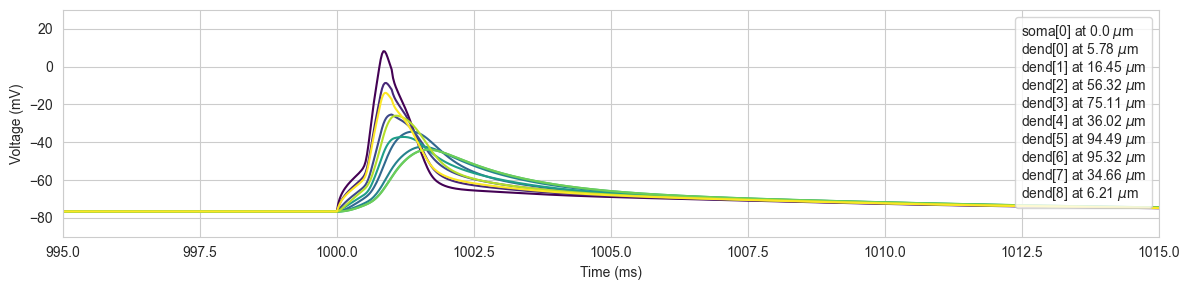

In [72]:
all_recordings = bpap.cell.get_allsections_voltagerecordings()
soma_key = [key for key in all_recordings.keys() if key.endswith("soma[0]")][0]

time = cell.get_time()
soma_voltage = all_recordings[soma_key]

# Define the figure size
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

subtree = list(all_recordings.keys())[:10]
# Define colormap
color_map = get_cmap('viridis', len(subtree))
distances = bpap.distances_to_soma()
# plot the voltage recordings from the subtree
for i,section in enumerate(subtree):
    voltage = all_recordings[section]
    distance = round(distances[section], 2)
    section_name = section.rsplit(".")[-1].split("[")[0]  # e.g. "dend"
    section_idx = int(section.rsplit(".")[-1].split("[")[1].split("]")[0])  # e.g. 0
    attribute_value = getattr(cell.cell.getCell(), section_name)
    section = next(islice(attribute_value, section_idx, None))
    # section e.g. cADpyr_L2TPC_bluecellulab_x[0].dend[0]
    ax.plot(time, voltage, label=f"{section_name}[{section_idx}] at {distance} $\mu$m", color=color_map(i))
    ax.legend(loc="upper right")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.set_ylim(-90, 30)  # Set y-axis limits
    ax.set_xlim(995, 1015)  # Set x-axis limits

plt.tight_layout()  # This ensures that the plots don't overlap
plt.show()

/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_2522/2640247676.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


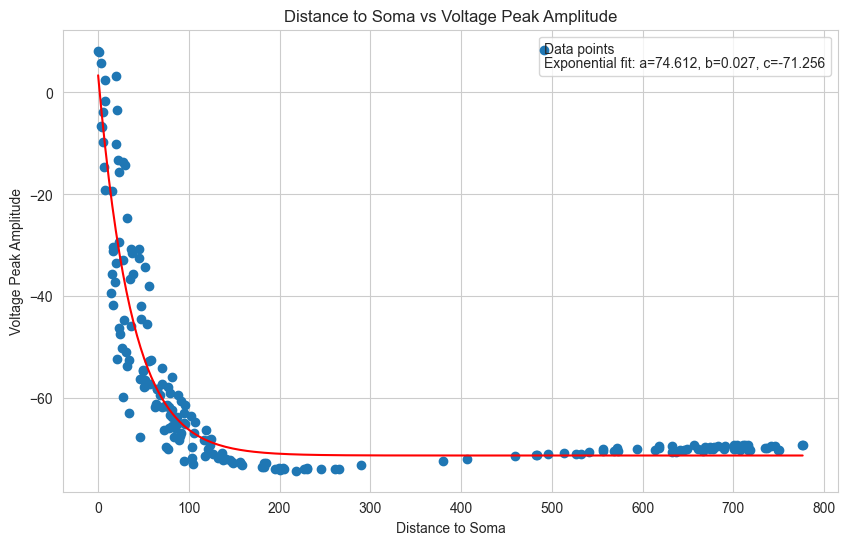

In [73]:
distances = list(distances_to_soma.values())
voltages = list(voltage_attenuation.values())

# The exponential that we wish to fit
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Use curve_fit to find the best parameters
popt, pcov = curve_fit(exponential_decay, distances, voltages)

# Create an array of x values for plotting
x_vals = np.linspace(min(distances), max(distances), 200)

# Plot the original data and the fitted function
plt.figure(figsize=(10, 6))
plt.scatter(distances, voltages, label='Data points')
plt.plot(x_vals, exponential_decay(x_vals, *popt), color='red', label='Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.title('Distance to Soma vs Voltage Peak Amplitude')
plt.xlabel('Distance to Soma')
plt.ylabel('Voltage Peak Amplitude')
plt.legend()
plt.show()

### Plotting Peak Delays vs Distance to Soma

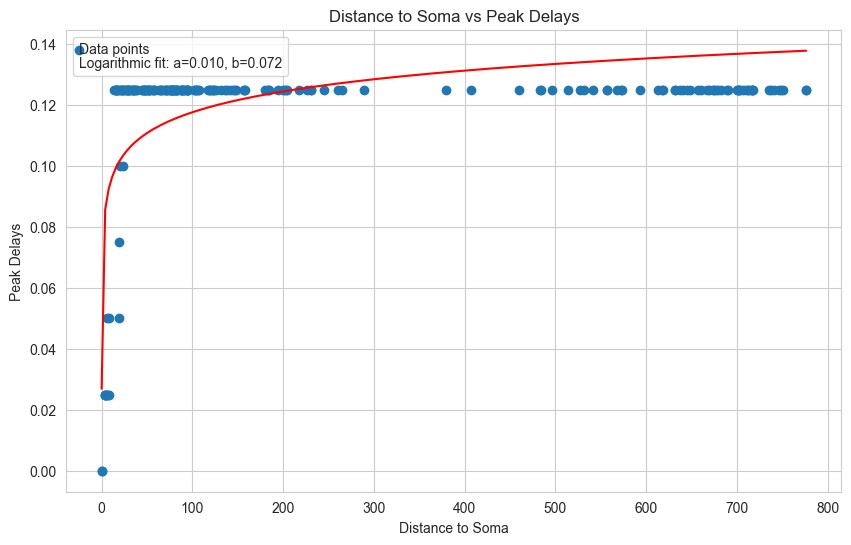

In [74]:
# Convert to lists for easier manipulation
distances = list(distances_to_soma.values())
delays = list(peak_delays.values())

def log_func(x, a, b):
    return a * np.log(x) + b

# Since log(0) is undefined, we add a small constant to distances
distances_shifted = np.array(distances) + 0.01 

popt, pcov = curve_fit(log_func, distances_shifted, delays)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(distances, delays, label='Data points')

# Plot the fitted function
x_vals = np.linspace(min(distances_shifted), max(distances_shifted), 200)
plt.plot(x_vals, log_func(x_vals, *popt), color='red', label='Logarithmic fit: a=%5.3f, b=%5.3f' % tuple(popt))


# Labels and title
plt.title('Distance to Soma vs Peak Delays')
plt.xlabel('Distance to Soma')
plt.ylabel('Peak Delays')

# Legend
plt.legend()

plt.show()